# Do EOF analysis on the SST and fCO2 for comparison with observations

## Imports

In [13]:
import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask as da
from dask.diagnostics import ProgressBar

# plotting packages
#import seaborn as sb
#sb.set(style='ticks')
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil

import xesmf as xe 

wrkdir = "/expanse/lustre/projects/ciw112/pbuchanan/JRA55"
os.chdir(wrkdir)
print(os.getcwd())

# activate the dask progress bar
#ProgressBar().register()

# ignore warnings
import warnings
warnings.filterwarnings("ignore")


/expanse/lustre/projects/ciw112/pbuchanan/JRA55


## Load model data

In [15]:
%%time

temp = xr.open_dataset('JRA55_pic_1m_ts_1958-2022.nc')['thetao'].isel(deptht=0).squeeze()
fco2 = xr.open_dataset('JRA55_co2_1m_diad_T_1958-2022.nc')['Cflx']
area = xr.open_dataset('JRA55_co2_1m_diad_T_1958-2022.nc')['area']

temp

CPU times: user 35.9 ms, sys: 2.59 ms, total: 38.5 ms
Wall time: 38 ms


<xarray.DataArray 'thetao' (record: 65, time_counter: 12, y: 149, x: 182)> Size: 85MB
[21152040 values with dtype=float32]
Coordinates:
    deptht         float32 4B 5.0
    nav_lat        (y, x) float32 108kB ...
    nav_lon        (y, x) float32 108kB ...
    time_centered  (time_counter) object 96B ...
  * time_counter   (time_counter) object 96B 1958-01-16 12:00:00 ... 1958-12-...
Dimensions without coordinates: record, y, x
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  5400 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5400 s)
    cell_measures:       area: area

### Fix time and names

In [16]:
month = np.arange(1,13,1)
year = np.arange(1958.5,2022.51,1)

temp = temp.assign_coords(record=year)
temp = temp.assign_coords(time_counter=month)
temp = temp.rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month'})

fco2 = fco2.assign_coords(record=year)
fco2 = fco2.assign_coords(time_counter=month)
fco2 = fco2.rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month'})

# retrieve information
lon = temp.coords['lon']
lat = temp.coords['lat']

temp

<xarray.DataArray 'thetao' (year: 65, month: 12, y: 149, x: 182)> Size: 85MB
[21152040 values with dtype=float32]
Coordinates:
    deptht         float32 4B 5.0
    lat            (y, x) float32 108kB ...
    lon            (y, x) float32 108kB ...
    time_centered  (month) object 96B ...
  * year           (year) float64 520B 1.958e+03 1.96e+03 ... 2.022e+03
  * month          (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  5400 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5400 s)
    cell_measures:       area: area

## Monthly anomalies of the fields

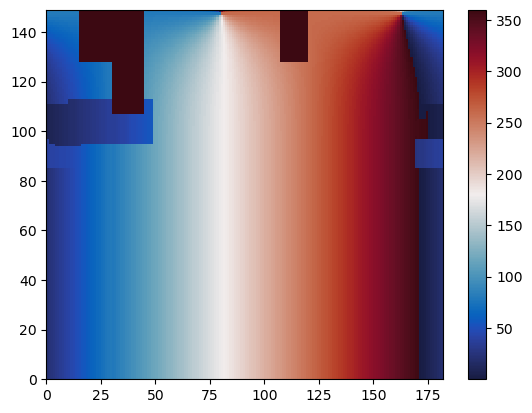

In [17]:
temp_anom = temp - temp.mean(dim='year')
fco2_anom = fco2 - fco2.mean(dim='year')

# Roll over the longitudes so the pacific isn't cut in half
temp_anom = temp_anom.roll(x=30, roll_coords=True)
fco2_anom = fco2_anom.roll(x=30, roll_coords=True)

# Make all longitudes positive
lon = temp_anom.coords['lon']
lat = temp_anom.coords['lat']
lon_positive = lon.where(lon >= 0.0, lon + 360.0)
temp_anom = temp_anom.assign_coords({"lon":lon_positive})
fco2_anom = fco2_anom.assign_coords({"lon":lon_positive})

plt.figure()
plt.pcolormesh(fco2_anom.coords['lon'], cmap=cmo.balance)
plt.colorbar()


## Isolate the South Indian and South Pacific

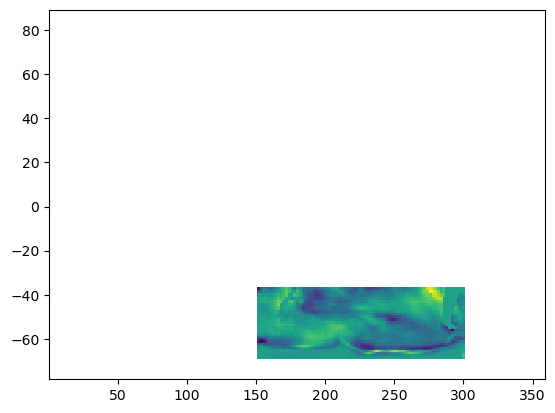

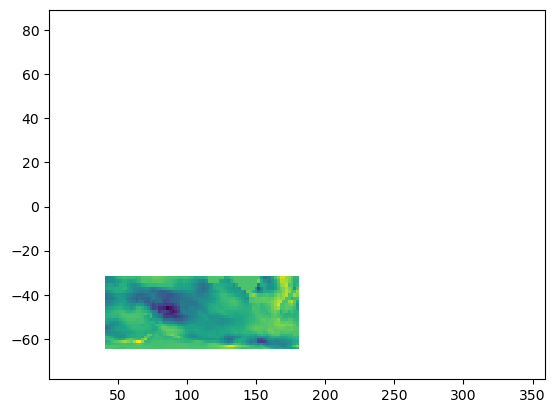

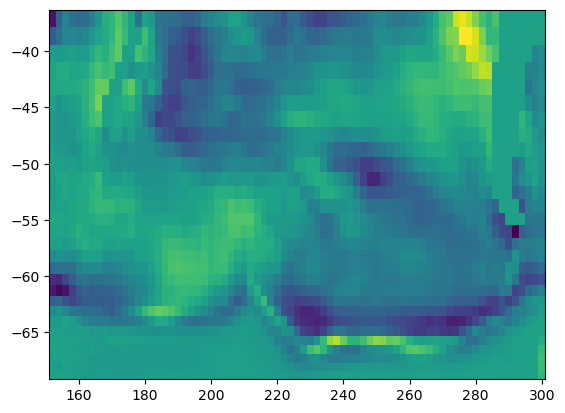

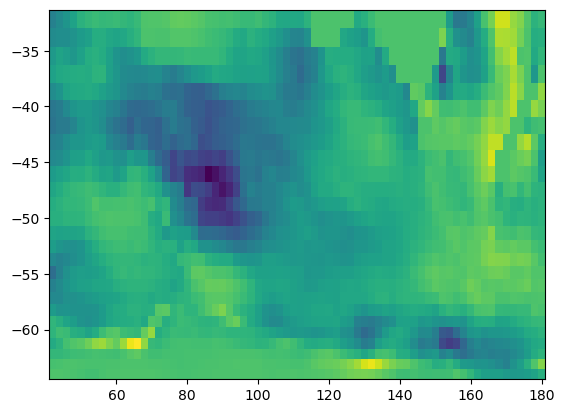

In [18]:
### isolate the south Pacific between 170-320 E and 20-90 S
plon1 = 150.5; plon2 = 300.5
plat1 = -69.5; plat2 = -35.5
# isolate the south Indian between 60-180 E and 20-90 S
ilon1 = 40.5; ilon2 = 180.5
ilat1 = -64.5; ilat2 = -30.5

spac_temp_anom = temp_anom.where((temp_anom.coords['lon'] > plon1) & (temp_anom.coords['lon'] < plon2), other=np.nan)
spac_temp_anom = spac_temp_anom.where((spac_temp_anom.coords['lat'] > plat1) & (spac_temp_anom.coords['lat'] < plat2), other=np.nan)
spac_fco2_anom = fco2_anom.where((fco2_anom.coords['lon'] > plon1) & (fco2_anom.coords['lon'] < plon2), other=np.nan)
spac_fco2_anom = spac_fco2_anom.where((spac_fco2_anom.coords['lat'] > plat1) & (spac_fco2_anom.coords['lat'] < plat2), other=np.nan)
spac_area = area.where((temp_anom.coords['lon'] > plon1) & (temp_anom.coords['lon'] < plon2), other=np.nan)
spac_area = spac_area.where((spac_temp_anom.coords['lat'] > plat1) & (spac_temp_anom.coords['lat'] < plat2), other=np.nan)

sind_temp_anom = temp_anom.where((temp_anom.coords['lon'] > ilon1) & (temp_anom.coords['lon'] < ilon2), other=np.nan)
sind_temp_anom = sind_temp_anom.where((sind_temp_anom.coords['lat'] > ilat1) & (sind_temp_anom.coords['lat'] < ilat2), other=np.nan)
sind_fco2_anom = fco2_anom.where((fco2_anom.coords['lon'] > ilon1) & (fco2_anom.coords['lon'] < ilon2), other=np.nan)
sind_fco2_anom = sind_fco2_anom.where((sind_fco2_anom.coords['lat'] > ilat1) & (sind_fco2_anom.coords['lat'] < ilat2), other=np.nan)
sind_area = area.where((fco2_anom.coords['lon'] > ilon1) & (fco2_anom.coords['lon'] < ilon2), other=np.nan)
sind_area = sind_area.where((sind_fco2_anom.coords['lat'] > ilat1) & (sind_fco2_anom.coords['lat'] < ilat2), other=np.nan)

plt.figure()
plt.pcolormesh(spac_fco2_anom.coords['lon'], spac_fco2_anom.coords['lat'], spac_fco2_anom.sel(year=1970.5, month=8))
plt.figure()
plt.pcolormesh(sind_fco2_anom.coords['lon'], sind_fco2_anom.coords['lat'], sind_fco2_anom.sel(year=1970.5, month=8))

spac_temp_anom = spac_temp_anom.where(~np.isnan(spac_temp_anom), drop=True)
sind_temp_anom = sind_temp_anom.where(~np.isnan(sind_temp_anom), drop=True)
spac_fco2_anom = spac_fco2_anom.where(~np.isnan(spac_fco2_anom), drop=True)
sind_fco2_anom = sind_fco2_anom.where(~np.isnan(sind_fco2_anom), drop=True)
spac_area = spac_area.where(~np.isnan(spac_area), drop=True)
sind_area = sind_area.where(~np.isnan(sind_area), drop=True)


plt.figure()
plt.pcolormesh(spac_fco2_anom.coords['lon'], spac_fco2_anom.coords['lat'], spac_fco2_anom.sel(year=1970.5, month=8))
plt.figure()
plt.pcolormesh(sind_fco2_anom.coords['lon'], sind_fco2_anom.coords['lat'], sind_fco2_anom.sel(year=1970.5, month=8))


## Blend the years and months into one time dimension

In [20]:
from datetime import datetime, timedelta

start_date = datetime(1958, 1, 1)
end_date = datetime(2022, 12, 31)
time = pd.date_range(start=start_date, end=end_date, freq="MS") + pd.DateOffset(days=14)
time

# blend years and months into one time dimension
spac_temp_anom = spac_temp_anom.stack(time=("year", "month")).drop_vars(['year', 'month', 'time_centered']).assign_coords(time=time)
sind_temp_anom = sind_temp_anom.stack(time=("year", "month")).drop_vars(['year', 'month', 'time_centered']).assign_coords(time=time)
spac_fco2_anom = spac_fco2_anom.stack(time=("year", "month")).drop_vars(['year', 'month', 'time_centered']).assign_coords(time=time)
sind_fco2_anom = sind_fco2_anom.stack(time=("year", "month")).drop_vars(['year', 'month', 'time_centered']).assign_coords(time=time)



<xarray.DataArray 'Cflx' (y: 29, x: 75, time: 780)> Size: 7MB
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-9.14275056e-09, -1.01915063e-08, -2.41861944e-08, ...,
          2.38504660e-10,  1.14332155e-09,  1.74393544e-09],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.16260548e-08,  2.68663669e-09, -1.82102422e-09, ...,
          1.60089382e-08,  8.96721275e-09,  5.99598593e-10]],

       [[-7.52721263e-09, -2.05392965e-08, -2.80392918e-08, ...,
          8.29327718e-11,  6.14749140e-09,  1.45545265e-08],
        [-3.63716346e-09, -2.07303810e-08, -3.38311352e-08, ...,
          1.15205445e-09,  4.66594630e-09,  1.29244118e-08],
        [-1.04169704e-08, -2.41135485e-08, -3.73417208e-08, ...,
          5.87817794e-10,  2.06491779e-09,  1.46338248e-08],
...
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-2.15931344e-08, -1.75032504e-08, -2.68850009e-08, ...,
          5.71225627e-08,  8.06650746e-08,  5.85143169e-08],
        [-1.61880394e-08, -1.00721174e-08, -1.98712584e-08, ...,
          4.56692746e-08,  5.20048360e-08,  4.30436771e-08],
        [-1.58046181e-08, -8.78188811e-09, -1.94572447e-08, ...,
          3.35140129e-08,  4.01354967e-08,  3.55684691e-08],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]],
      dtype=float32)
Coordinates:
    lat      (y, x) float32 9kB -68.79 -68.79 -68.79 ... -37.1 -37.1 -37.1
    lon      (y, x) float32 9kB 152.0 154.0 156.0 158.0 ... 296.0 298.0 300.0
    deptht   float32 4B 5.0
  * time     (time) datetime64[ns] 6kB 1958-01-15 1958-02-15 ... 2022-12-15
Dimensions without coordinates: y, x

## Perform the EOF analysis

### Temperature

In [24]:
weights = spac_area.mean(dim='record') / spac_area.mean(dim='record').sum()
W_pac = weights**0.5
X = spac_temp_anom * W_pac
Xpac = X.stack(space=("y","x"))

U, S, V = np.linalg.svd(Xpac.T.values, full_matrices=False)

### reconstruct the dimensions of the original data

U_ = Xpac.T * 0 + U
U_pac_sst = U_.unstack('space') * W_pac**(-1)
U_pac_sst = U_pac_sst.rename({"time":"mode"})
U_pac_sst = U_pac_sst.assign_coords({"mode":np.arange(len(S))})

S_pac_sst = xr.DataArray(
    S,
    dims=["mode"],
    coords={"mode":np.arange(len(S))}
)

V_pac_sst = xr.DataArray(
    V.T,
    dims=["time","mode"],
    coords={
        "time":Xpac.coords['time'].values,
        "mode":np.arange(len(S))
    }
)

# variance explained
S2_pac_sst = S_pac_sst**2.0
VE_pac_sst = S2_pac_sst / S2_pac_sst.sum()

print(np.shape(Xpac.T))
print(np.shape(U_pac_sst))
print(np.shape(S_pac_sst))
print(np.shape(V_pac_sst))
print(np.shape(VE_pac_sst))


(2175, 780)
(780, 29, 75)
(780,)
(780, 780)
(780,)


In [25]:
weights = sind_area.mean(dim='record') / sind_area.mean(dim='record').sum()
W_ind = weights**0.5
X = sind_temp_anom * W_ind
Xind = X.stack(space=("y","x"))

U, S, V = np.linalg.svd(Xind.T.values, full_matrices=False)

### reconstruct the dimensions of the original data

U_ = Xind.T * 0 + U
U_ind_sst = U_.unstack('space') * W_ind**(-1)
U_ind_sst = U_ind_sst.rename({"time":"mode"})
U_ind_sst = U_ind_sst.assign_coords({"mode":np.arange(len(S))})

S_ind_sst = xr.DataArray(
    S,
    dims=["mode"],
    coords={"mode":np.arange(len(S))}
)

V_ind_sst = xr.DataArray(
    V.T,
    dims=["time","mode"],
    coords={
        "time":Xind.coords['time'].values,
        "mode":np.arange(len(S))
    }
)

# variance explained
S2_ind_sst = S_ind_sst**2.0
VE_ind_sst = S2_ind_sst / S2_ind_sst.sum()

print(np.shape(Xind.T))
print(np.shape(U_ind_sst))
print(np.shape(S_ind_sst))
print(np.shape(V_ind_sst))
print(np.shape(VE_ind_sst))


(1872, 780)
(780, 26, 72)
(780,)
(780, 780)
(780,)


### CO2 flux

In [26]:
weights = spac_area.mean(dim='record') / spac_area.mean(dim='record').sum()
W_pac = weights**0.5
X = spac_fco2_anom * W_pac
Xpac = X.stack(space=("y","x"))

U, S, V = np.linalg.svd(Xpac.T.values, full_matrices=False)

### reconstruct the dimensions of the original data

U_ = Xpac.T * 0 + U
U_pac_co2 = U_.unstack('space') * W_pac**(-1)
U_pac_co2 = U_pac_co2.rename({"time":"mode"})
U_pac_co2 = U_pac_co2.assign_coords({"mode":np.arange(len(S))})

S_pac_co2 = xr.DataArray(
    S,
    dims=["mode"],
    coords={"mode":np.arange(len(S))}
)

V_pac_co2 = xr.DataArray(
    V.T,
    dims=["time","mode"],
    coords={
        "time":Xpac.coords['time'].values,
        "mode":np.arange(len(S))
    }
)

# variance explained
S2_pac_co2 = S_pac_co2**2.0
VE_pac_co2 = S2_pac_co2 / S2_pac_co2.sum()

print(np.shape(Xpac.T))
print(np.shape(U_pac_co2))
print(np.shape(S_pac_co2))
print(np.shape(V_pac_co2))
print(np.shape(VE_pac_co2))


(2175, 780)
(780, 29, 75)
(780,)
(780, 780)
(780,)


In [27]:
weights = sind_area.mean(dim='record') / sind_area.mean(dim='record').sum()
W_ind = weights**0.5
X = sind_fco2_anom * W_ind
Xind = X.stack(space=("y","x"))

U, S, V = np.linalg.svd(Xind.T.values, full_matrices=False)

### reconstruct the dimensions of the original data

U_ = Xind.T * 0 + U
U_ind_co2 = U_.unstack('space') * W_ind**(-1)
U_ind_co2 = U_ind_co2.rename({"time":"mode"})
U_ind_co2 = U_ind_co2.assign_coords({"mode":np.arange(len(S))})

S_ind_co2 = xr.DataArray(
    S,
    dims=["mode"],
    coords={"mode":np.arange(len(S))}
)

V_ind_co2 = xr.DataArray(
    V.T,
    dims=["time","mode"],
    coords={
        "time":Xind.coords['time'].values,
        "mode":np.arange(len(S))
    }
)

# variance explained
S2_ind_co2 = S_ind_co2**2.0
VE_ind_co2 = S2_ind_co2 / S2_ind_co2.sum()

print(np.shape(Xind.T))
print(np.shape(U_ind_co2))
print(np.shape(S_ind_co2))
print(np.shape(V_ind_co2))
print(np.shape(VE_ind_co2))


(1872, 780)
(780, 26, 72)
(780,)
(780, 780)
(780,)


## Plot the variance explained

Total variance explained in Indian by first 2 modes = 0.39159757
Total variance explained in Pacific by first 2 modes = 0.3971849


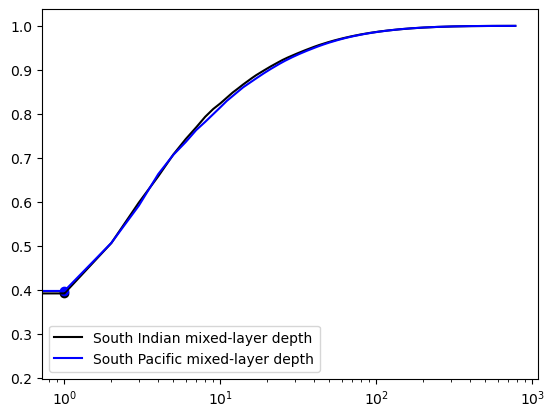

In [28]:
imodes = 1
print("Total variance explained in Indian by first %i modes ="%(imodes+1), VE_ind_sst.cumsum().sel(mode=imodes).values)
print("Total variance explained in Pacific by first %i modes ="%(imodes+1), VE_pac_sst.cumsum().sel(mode=imodes).values)

plt.figure()
plt.plot(np.arange(len(VE_ind_sst)), VE_ind_sst.cumsum(), color='k', label="South Indian SST depth")
plt.plot(np.arange(len(VE_pac_sst)), VE_pac_sst.cumsum(), color='b', label="South Pacific SST depth")
plt.scatter(imodes, VE_ind_sst.cumsum().sel(mode=imodes), marker='o', color='k')
plt.scatter(imodes, VE_pac_sst.cumsum().sel(mode=imodes), marker='o', color='b')
plt.legend()
plt.xscale('log')

Total variance explained in Indian by first 2 modes = 0.5143194
Total variance explained in Pacific by first 2 modes = 0.42146105


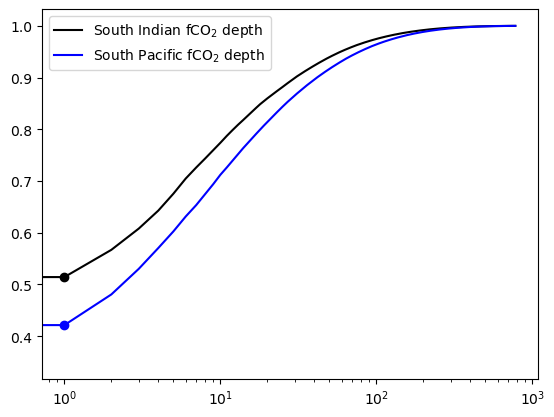

In [29]:
imodes = 1
print("Total variance explained in Indian by first %i modes ="%(imodes+1), VE_ind_co2.cumsum().sel(mode=imodes).values)
print("Total variance explained in Pacific by first %i modes ="%(imodes+1), VE_pac_co2.cumsum().sel(mode=imodes).values)

plt.figure()
plt.plot(np.arange(len(VE_ind_co2)), VE_ind_co2.cumsum(), color='k', label="South Indian fCO$_2$ depth")
plt.plot(np.arange(len(VE_pac_co2)), VE_pac_co2.cumsum(), color='b', label="South Pacific fCO$_2$ depth")
plt.scatter(imodes, VE_ind_co2.cumsum().sel(mode=imodes), marker='o', color='k')
plt.scatter(imodes, VE_pac_co2.cumsum().sel(mode=imodes), marker='o', color='b')
plt.legend()
plt.xscale('log')

## Regrid the EOFs to a regular grid for plotting

In [30]:
%%time

target_grid = xr.Dataset(
    {
        "lat": (["lat"], np.arange(plat1,plat2+0.5,0.5)),
        "lon": (["lon"], np.arange(plon1,plon2+0.5,0.5)),
    }
)

regridder = xe.Regridder(U_pac_sst, target_grid, 'bilinear', ignore_degenerate=True, periodic=True)
U_pac_sst_reg = regridder(U_pac_sst)
regridder = xe.Regridder(U_pac_co2, target_grid, 'bilinear', ignore_degenerate=True, periodic=True)
U_pac_co2_reg = regridder(U_pac_co2)

target_grid = xr.Dataset(
    {
        "lat": (["lat"], np.arange(ilat1,ilat2+0.5,0.5)),
        "lon": (["lon"], np.arange(ilon1,ilon2+0.5,0.5)),
    }
)

regridder = xe.Regridder(U_ind_sst, target_grid, 'bilinear', ignore_degenerate=True, periodic=True)
U_ind_sst_reg = regridder(U_ind_sst)
regridder = xe.Regridder(U_ind_co2, target_grid, 'bilinear', ignore_degenerate=True, periodic=True)
U_ind_co2_reg = regridder(U_ind_co2)


CPU times: user 2.53 s, sys: 153 ms, total: 2.69 s
Wall time: 2.75 s


## Plot

Text(0.05, 1.05, 'j')

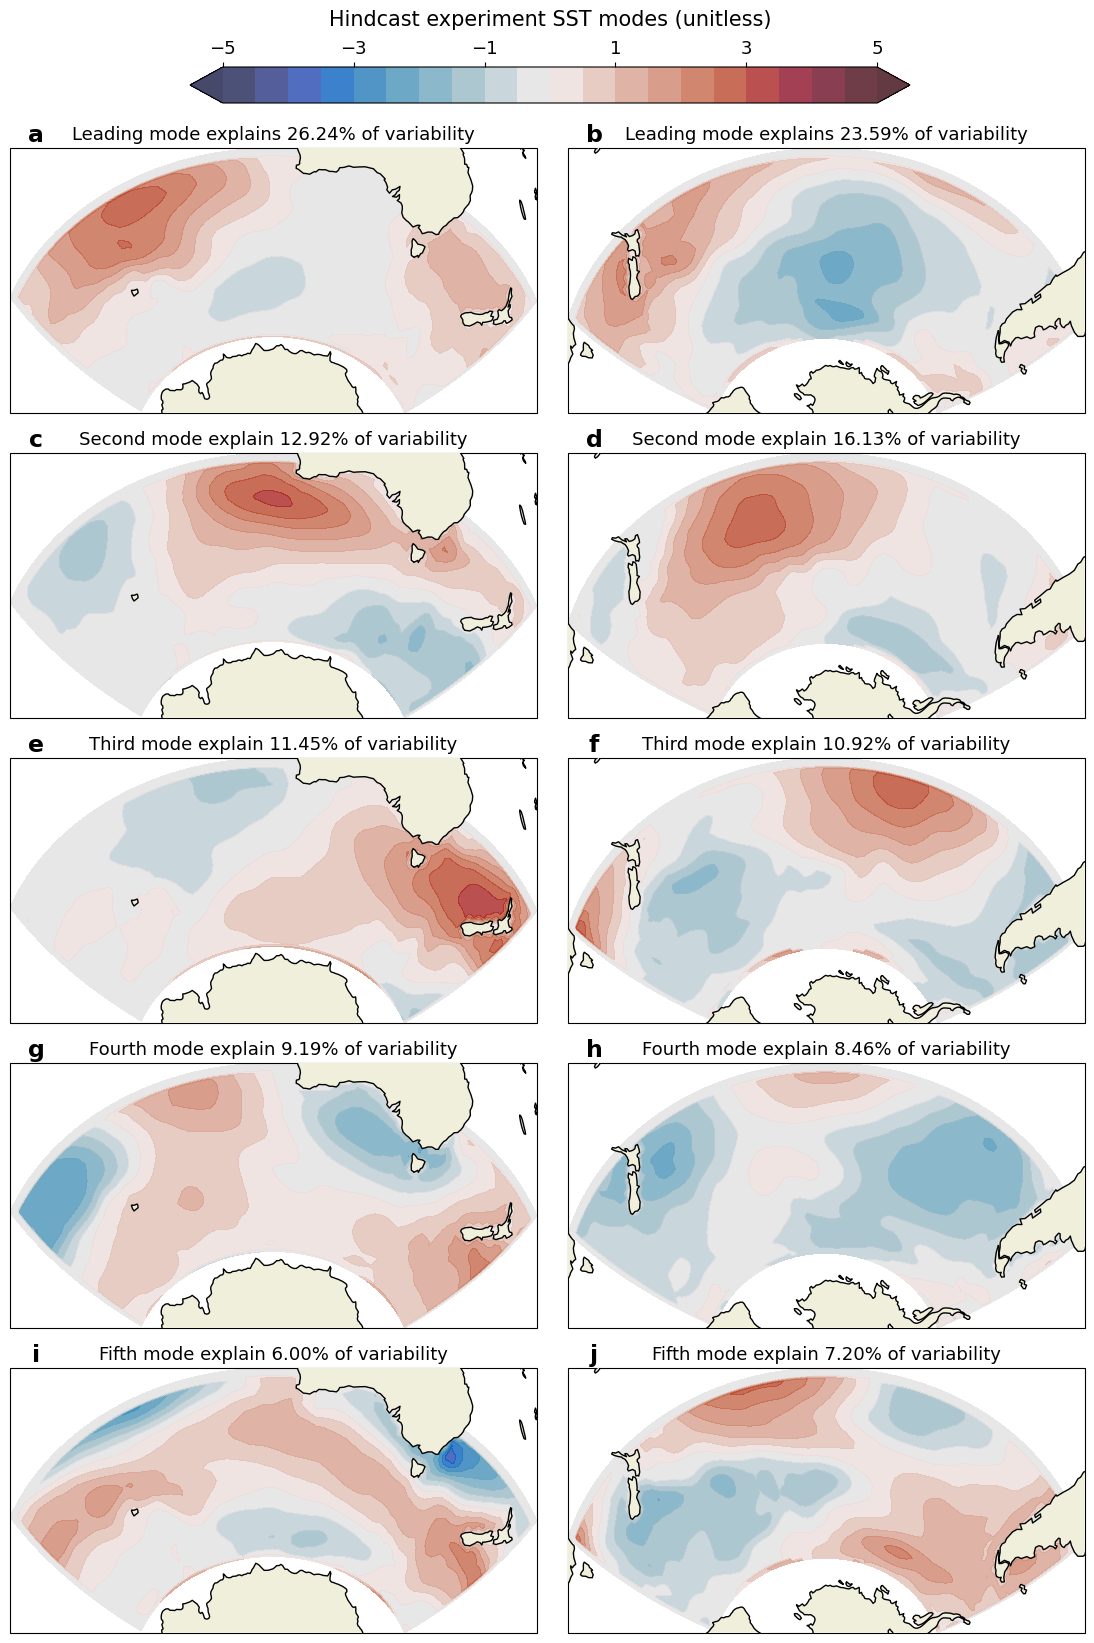

In [31]:
#%% Look at what the leading modes are in terms of spatial patterns

sind_proj = ccrs.Orthographic(central_latitude=-55, central_longitude=110)
spac_proj = ccrs.Orthographic(central_latitude=-60, central_longitude=225)

paclons = U_pac_sst_reg.coords['lon']
paclats = U_pac_sst_reg.coords['lat']
indlons = U_ind_sst_reg.coords['lon']
indlats = U_ind_sst_reg.coords['lat']


levs = np.arange(-5,5.1,0.5)
colmap = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15
wid = 1.0

fig = plt.figure(figsize=(12,18), facecolor='w')
gs = GridSpec(5,2)

ax1 = plt.subplot(gs[0,0], projection=sind_proj)
ax2 = plt.subplot(gs[0,1], projection=spac_proj)
ax3 = plt.subplot(gs[1,0], projection=sind_proj)
ax4 = plt.subplot(gs[1,1], projection=spac_proj)
ax5 = plt.subplot(gs[2,0], projection=sind_proj)
ax6 = plt.subplot(gs[2,1], projection=spac_proj)
ax7 = plt.subplot(gs[3,0], projection=sind_proj)
ax8 = plt.subplot(gs[3,1], projection=spac_proj)
ax9 = plt.subplot(gs[4,0], projection=sind_proj)
ax10 = plt.subplot(gs[4,1], projection=spac_proj)

ax1.add_feature(cfeature.LAND, zorder=3)
ax1.add_feature(cfeature.COASTLINE, zorder=3)
ax2.add_feature(cfeature.LAND, zorder=3)
ax2.add_feature(cfeature.COASTLINE, zorder=3)
ax3.add_feature(cfeature.LAND, zorder=3)
ax3.add_feature(cfeature.COASTLINE, zorder=3)
ax4.add_feature(cfeature.LAND, zorder=3)
ax4.add_feature(cfeature.COASTLINE, zorder=3)
ax5.add_feature(cfeature.LAND, zorder=3)
ax5.add_feature(cfeature.COASTLINE, zorder=3)
ax6.add_feature(cfeature.LAND, zorder=3)
ax6.add_feature(cfeature.COASTLINE, zorder=3)
ax7.add_feature(cfeature.LAND, zorder=3)
ax7.add_feature(cfeature.COASTLINE, zorder=3)
ax8.add_feature(cfeature.LAND, zorder=3)
ax8.add_feature(cfeature.COASTLINE, zorder=3)
ax9.add_feature(cfeature.LAND, zorder=3)
ax9.add_feature(cfeature.COASTLINE, zorder=3)
ax10.add_feature(cfeature.LAND, zorder=3)
ax10.add_feature(cfeature.COASTLINE, zorder=3)


p1 = ax1.contourf(indlons,indlats, U_ind_sst_reg.sel(mode=0), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p2 = ax2.contourf(paclons,paclats, U_pac_sst_reg.sel(mode=0), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
plt.text(0.5,1.05,'Leading mode explains %.2f%% of variability'%(VE_ind_sst.sel(mode=0).values*100), transform=ax1.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Leading mode explains %.2f%% of variability'%(VE_pac_sst.sel(mode=0).values*100), transform=ax2.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 1 
p3 = ax3.contourf(indlons,indlats, U_ind_sst_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p4 = ax4.contourf(paclons,paclats, U_pac_sst_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
plt.text(0.5,1.05,'Second mode explain %.2f%% of variability'%(VE_ind_sst.sel(mode=imodes).values*100), transform=ax3.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Second mode explain %.2f%% of variability'%(VE_pac_sst.sel(mode=imodes).values*100), transform=ax4.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 2 
p5 = ax5.contourf(indlons,indlats, U_ind_sst_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p6 = ax6.contourf(paclons,paclats, U_pac_sst_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
plt.text(0.5,1.05,'Third mode explain %.2f%% of variability'%(VE_ind_sst.sel(mode=imodes).values*100), transform=ax5.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Third mode explain %.2f%% of variability'%(VE_pac_sst.sel(mode=imodes).values*100), transform=ax6.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 3 
p7 = ax7.contourf(indlons,indlats, U_ind_sst_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p8 = ax8.contourf(paclons,paclats, U_pac_sst_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
plt.text(0.5,1.05,'Fourth mode explain %.2f%% of variability'%(VE_ind_sst.sel(mode=imodes).values*100), transform=ax7.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Fourth mode explain %.2f%% of variability'%(VE_pac_sst.sel(mode=imodes).values*100), transform=ax8.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 4 
p9 = ax9.contourf(indlons,indlats, U_ind_sst_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p10 = ax10.contourf(paclons,paclats, U_pac_sst_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
plt.text(0.5,1.05,'Fifth mode explain %.2f%% of variability'%(VE_ind_sst.sel(mode=imodes).values*100), transform=ax9.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Fifth mode explain %.2f%% of variability'%(VE_pac_sst.sel(mode=imodes).values*100), transform=ax10.transAxes, va='center', ha='center', fontsize=fstic)

cbax = fig.add_axes([0.2,0.9,0.6,0.02])
cbar1 = plt.colorbar(p1, cax=cbax, orientation='horizontal', ticks=levs[::4])
cbar1.ax.tick_params(labelsize=fstic, labelbottom=False, bottom=False, labeltop=True, top=True)
cbar1.ax.set_xlabel('Hindcast experiment SST modes (unitless)', fontsize=fslab, labelpad=10)
cbar1.ax.xaxis.set_label_position('top')

plt.subplots_adjust(left=0.05, top=0.875, right=0.95, bottom=0.05, wspace=0.05, hspace=0.15)

xx = 0.05; yy = 1.05
plt.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes)
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)
plt.text(xx,yy,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5.transAxes)
plt.text(xx,yy,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes)
plt.text(xx,yy,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)
plt.text(xx,yy,'h', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax8.transAxes)
plt.text(xx,yy,'i', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax9.transAxes)
plt.text(xx,yy,'j', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax10.transAxes)



In [32]:
fig.savefig("/home/pbuchanan/analysis_samw/sst_eofs.png", dpi=300)


Text(0.05, 1.05, 'j')

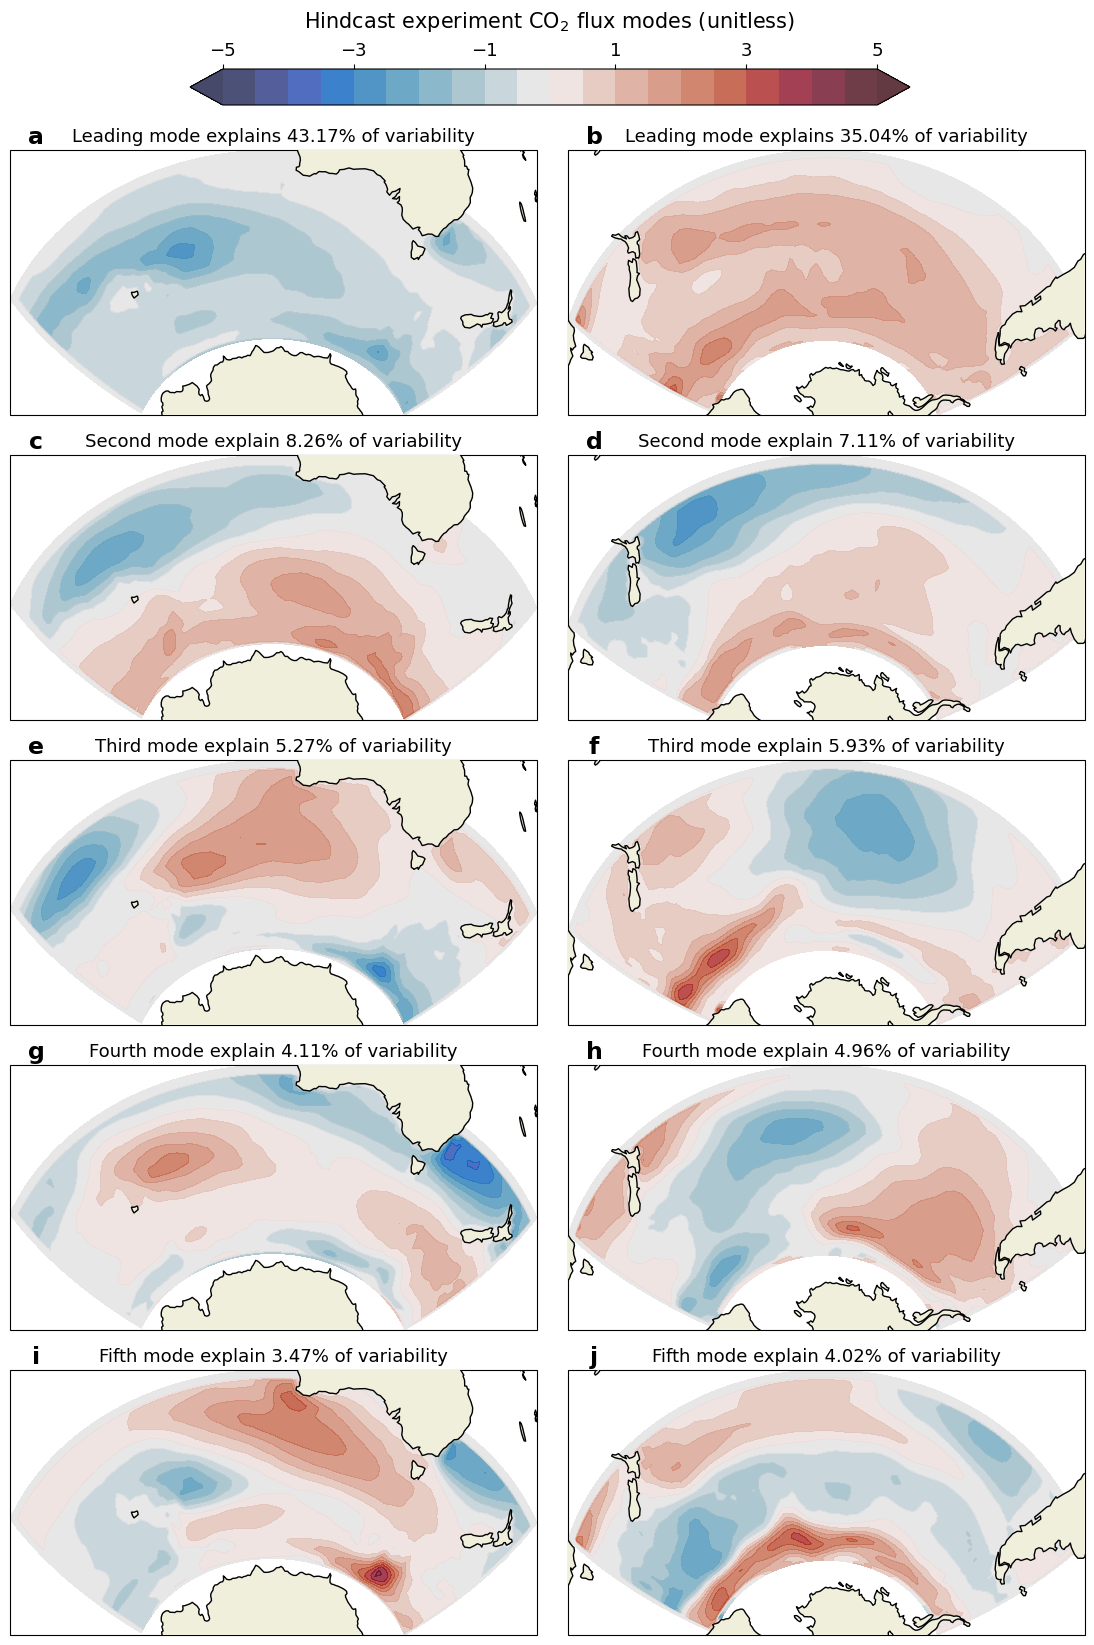

In [33]:
#%% Look at what the leading modes are in terms of spatial patterns

sind_proj = ccrs.Orthographic(central_latitude=-55, central_longitude=110)
spac_proj = ccrs.Orthographic(central_latitude=-60, central_longitude=225)

paclons = U_pac_co2_reg.coords['lon']
paclats = U_pac_co2_reg.coords['lat']
indlons = U_ind_co2_reg.coords['lon']
indlats = U_ind_co2_reg.coords['lat']


levs = np.arange(-5,5.1,0.5)
colmap = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15
wid = 1.0

fig = plt.figure(figsize=(12,18), facecolor='w')
gs = GridSpec(5,2)

ax1 = plt.subplot(gs[0,0], projection=sind_proj)
ax2 = plt.subplot(gs[0,1], projection=spac_proj)
ax3 = plt.subplot(gs[1,0], projection=sind_proj)
ax4 = plt.subplot(gs[1,1], projection=spac_proj)
ax5 = plt.subplot(gs[2,0], projection=sind_proj)
ax6 = plt.subplot(gs[2,1], projection=spac_proj)
ax7 = plt.subplot(gs[3,0], projection=sind_proj)
ax8 = plt.subplot(gs[3,1], projection=spac_proj)
ax9 = plt.subplot(gs[4,0], projection=sind_proj)
ax10 = plt.subplot(gs[4,1], projection=spac_proj)

ax1.add_feature(cfeature.LAND, zorder=3)
ax1.add_feature(cfeature.COASTLINE, zorder=3)
ax2.add_feature(cfeature.LAND, zorder=3)
ax2.add_feature(cfeature.COASTLINE, zorder=3)
ax3.add_feature(cfeature.LAND, zorder=3)
ax3.add_feature(cfeature.COASTLINE, zorder=3)
ax4.add_feature(cfeature.LAND, zorder=3)
ax4.add_feature(cfeature.COASTLINE, zorder=3)
ax5.add_feature(cfeature.LAND, zorder=3)
ax5.add_feature(cfeature.COASTLINE, zorder=3)
ax6.add_feature(cfeature.LAND, zorder=3)
ax6.add_feature(cfeature.COASTLINE, zorder=3)
ax7.add_feature(cfeature.LAND, zorder=3)
ax7.add_feature(cfeature.COASTLINE, zorder=3)
ax8.add_feature(cfeature.LAND, zorder=3)
ax8.add_feature(cfeature.COASTLINE, zorder=3)
ax9.add_feature(cfeature.LAND, zorder=3)
ax9.add_feature(cfeature.COASTLINE, zorder=3)
ax10.add_feature(cfeature.LAND, zorder=3)
ax10.add_feature(cfeature.COASTLINE, zorder=3)


p1 = ax1.contourf(indlons,indlats, U_ind_co2_reg.sel(mode=0), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p2 = ax2.contourf(paclons,paclats, U_pac_co2_reg.sel(mode=0), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
plt.text(0.5,1.05,'Leading mode explains %.2f%% of variability'%(VE_ind_co2.sel(mode=0).values*100), transform=ax1.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Leading mode explains %.2f%% of variability'%(VE_pac_co2.sel(mode=0).values*100), transform=ax2.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 1 
p3 = ax3.contourf(indlons,indlats, U_ind_co2_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p4 = ax4.contourf(paclons,paclats, U_pac_co2_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
plt.text(0.5,1.05,'Second mode explain %.2f%% of variability'%(VE_ind_co2.sel(mode=imodes).values*100), transform=ax3.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Second mode explain %.2f%% of variability'%(VE_pac_co2.sel(mode=imodes).values*100), transform=ax4.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 2 
p5 = ax5.contourf(indlons,indlats, U_ind_co2_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p6 = ax6.contourf(paclons,paclats, U_pac_co2_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
plt.text(0.5,1.05,'Third mode explain %.2f%% of variability'%(VE_ind_co2.sel(mode=imodes).values*100), transform=ax5.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Third mode explain %.2f%% of variability'%(VE_pac_co2.sel(mode=imodes).values*100), transform=ax6.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 3 
p7 = ax7.contourf(indlons,indlats, U_ind_co2_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p8 = ax8.contourf(paclons,paclats, U_pac_co2_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
plt.text(0.5,1.05,'Fourth mode explain %.2f%% of variability'%(VE_ind_co2.sel(mode=imodes).values*100), transform=ax7.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Fourth mode explain %.2f%% of variability'%(VE_pac_co2.sel(mode=imodes).values*100), transform=ax8.transAxes, va='center', ha='center', fontsize=fstic)

imodes = 4 
p9 = ax9.contourf(indlons,indlats, U_ind_co2_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
p10 = ax10.contourf(paclons,paclats, U_pac_co2_reg.sel(mode=imodes), transform=ccrs.PlateCarree(), cmap=colmap, levels=levs, extend='both')
plt.text(0.5,1.05,'Fifth mode explain %.2f%% of variability'%(VE_ind_co2.sel(mode=imodes).values*100), transform=ax9.transAxes, va='center', ha='center', fontsize=fstic)
plt.text(0.5,1.05,'Fifth mode explain %.2f%% of variability'%(VE_pac_co2.sel(mode=imodes).values*100), transform=ax10.transAxes, va='center', ha='center', fontsize=fstic)

cbax = fig.add_axes([0.2,0.9,0.6,0.02])
cbar1 = plt.colorbar(p1, cax=cbax, orientation='horizontal', ticks=levs[::4])
cbar1.ax.tick_params(labelsize=fstic, labelbottom=False, bottom=False, labeltop=True, top=True)
cbar1.ax.set_xlabel('Hindcast experiment CO$_2$ flux modes (unitless)', fontsize=fslab, labelpad=10)
cbar1.ax.xaxis.set_label_position('top')

plt.subplots_adjust(left=0.05, top=0.875, right=0.95, bottom=0.05, wspace=0.05, hspace=0.15)

xx = 0.05; yy = 1.05
plt.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes)
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)
plt.text(xx,yy,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5.transAxes)
plt.text(xx,yy,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes)
plt.text(xx,yy,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)
plt.text(xx,yy,'h', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax8.transAxes)
plt.text(xx,yy,'i', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax9.transAxes)
plt.text(xx,yy,'j', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax10.transAxes)



In [35]:
fig.savefig("/home/pbuchanan/analysis_samw/co2_eofs.png", dpi=300)
